In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.base import TransformerMixin
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [2]:
class FeatureSelection(TransformerMixin):
    def __init__(self, X_list):
        self.X_list = X_list
        self.sel_features = None
    
    def fit(self, X, y):
        train = pd.DataFrame(np.column_stack([X, y]))
        train.columns = np.concatenate((self.X_list, 'Y'), axis = None)
        with localconverter(ro.default_converter + pandas2ri.converter):
            rtrain = ro.conversion.py2rpy(train)
        
        ro.r('''
             rgfs = function(train) {
                 library(ranger)
                 
                 set.seed(0)
                 rg = ranger(Y ~ ., data = train,
                             classification = T,
                             importance = "impurity",
                             always.split.variables = c("creatinine_value_mg_dl", "bilirubin_value_mg_dl", "sodium", "inr"))
                 
                 importance = rg$variable.importance
                 importance = importance[order(importance, decreasing = T)]
                 importance.sel = importance[1:11]
                 
                 return(which(names(train) %in% names(importance.sel)) - 1)
             }
             ''')
        
        r_rgfs = ro.globalenv['rgfs']
        self.sel_features = np.asarray(r_rgfs(rtrain), dtype = int)
        return self
    
    def transform(self, X):
        return X[:, self.sel_features]

In [3]:
def Performance_Metrics(model, test_features, test_labels):
    predictions = model.predict(test_features)
    pred_prob   = model.predict_proba(test_features)[:, 1]
    
    print('\nModel performance on test data:')
    
    pre, rec, thresholds = metrics.precision_recall_curve(test_labels, pred_prob)
    
    accuracy  = metrics.accuracy_score(test_labels, predictions)
    F1        = metrics.f1_score(test_labels, predictions)
    precision = metrics.precision_score(test_labels, predictions)
    recall    = metrics.recall_score(test_labels, predictions)
    mcc       = metrics.matthews_corrcoef(test_labels, predictions)
    auc       = metrics.roc_auc_score(test_labels, pred_prob)
    aucpr     = metrics.auc(rec, pre)
    
    header = ['Metric', 'Test']
    table  = [
               ['Accuracy',  accuracy],
               ['F1',        F1],
               ['Precision', precision],
               ['Recall',    recall],
               ['MCC',       mcc],
               ['PR-AUC',    aucpr],
               ['AUC',       auc]
             ]
    print(pd.DataFrame(table, columns = header))
    
    return np.array([col[1] for col in table])

In [4]:
def ROC_Curve_CV(aucs, fprs, tprs):
    plt.style.use('ggplot')
    plt.figure()
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    
    interp_tprs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    n = len(aucs)
    colors = iter(cm.rainbow(np.linspace(1, 0, n)))
    for i in range(n):
        interp_tpr = np.interp(mean_fpr, fprs[i], tprs[i])
        interp_tpr[0] = 0.0
        interp_tprs.append(interp_tpr)
        
        plt.plot([0.0] + fprs[i], 
                 [0.0] + tprs[i], 
                 color = next(colors),
                 alpha = 0.4,
                 lw = 1,
                 label = 'ROC fold ' + str(i) + ' (area = %0.2f)' % aucs[i])
        
    plt.plot([0, 1], [0, 1],
             color = 'blue',
             alpha = 0.8,
             lw = 2,
             linestyle = '--',
             label = 'Chance')
    
    mean_tpr = np.mean(interp_tprs, axis = 0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs, ddof = 1)
    plt.plot(mean_fpr, mean_tpr,
             color = 'red',
             alpha = 0.8,
             lw = 2,
             label = r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc))
    
    std_tpr = np.std(interp_tprs, axis = 0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper,
                     color = 'grey',
                     alpha = 0.2,
                     label = r'$\pm$ 1 std. dev.')
    
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left', borderaxespad = 0.)
    
    plt.show()
    
    return np.append(mean_tpr, std_auc)

In [5]:
# Saving feature names
train_raw = pd.read_csv('train2_30_raw0.csv')
features_train_raw = train_raw.drop(['ThirtyMo',
                                     'MELD',
                                     'MELD_2016'],
                                    axis = 1)
features_train_list = features_train_raw.columns

# Define the grid parameters
estimators = Pipeline([
    ('MICE', IterativeImputer(sample_posterior = True, min_value = 0, random_state = 0)),
    ('rg', FeatureSelection(X_list = features_train_list)),
    ('SMOTE', SMOTE(random_state = 0, k_neighbors = 2)), 
    ('rf', RandomForestClassifier(min_impurity_decrease = 0.00001, random_state = 0))
])

hyper_parameters = {'rf__n_estimators':[100, 200, 300, 400], 
                    'rf__max_depth':[5, 10, 15, 20]}

grid_search_30 = GridSearchCV(estimator = estimators, 
                              param_grid = hyper_parameters,
                              scoring = 'f1',
                              cv = 4,
                              n_jobs = -1)

grid_search_90 = GridSearchCV(estimator = estimators, 
                              param_grid = hyper_parameters,
                              scoring = 'f1',
                              cv = 4,
                              n_jobs = -1)


Best n_estimators..... 100
Best max_depth........ 5
Best F1............... 0.0

Model performance on test data:
      Metric      Test
0   Accuracy  0.909091
1         F1  0.000000
2  Precision  0.000000
3     Recall  0.000000
4        MCC  0.000000
5     PR-AUC  0.083333
6        AUC  0.500000


/Users/morris16206/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/morris16206/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



Best n_estimators..... 100
Best max_depth........ 5
Best F1............... 0.0

Model performance on test data:
      Metric      Test
0   Accuracy  0.909091
1         F1  0.000000
2  Precision  0.000000
3     Recall  0.000000
4        MCC  0.000000
5     PR-AUC  0.071429
6        AUC  0.400000


/Users/morris16206/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/morris16206/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



Best n_estimators..... 100
Best max_depth........ 5
Best F1............... 0.0

Model performance on test data:
      Metric      Test
0   Accuracy  0.727273
1         F1  0.000000
2  Precision  0.000000
3     Recall  0.000000
4        MCC -0.149071
5     PR-AUC  0.100000
6        AUC  0.600000

Best n_estimators..... 100
Best max_depth........ 5
Best F1............... 0.0

Model performance on test data:
      Metric      Test
0   Accuracy  0.818182
1         F1  0.000000
2  Precision  0.000000
3     Recall  0.000000
4        MCC -0.100000
5     PR-AUC  0.083333
6        AUC  0.500000

Best n_estimators..... 100
Best max_depth........ 5
Best F1............... 0.0

Model performance on test data:
      Metric      Test
0   Accuracy  0.700000
1         F1  0.000000
2  Precision  0.000000
3     Recall  0.000000
4        MCC -0.166667
5     PR-AUC  0.062500
6        AUC  0.222222

Model performance for 5-fold cross-validation:
      Metric      Mean  Standard deviation
0   Accuracy  0.81

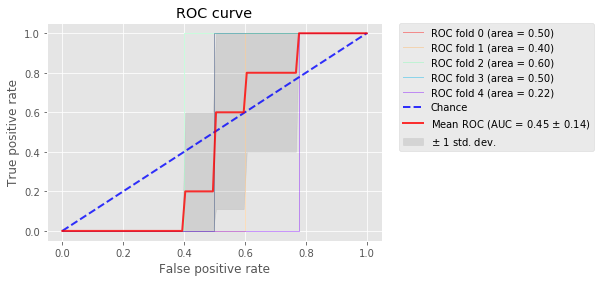

In [6]:
# For died within 30 days outcome
mean_perf = np.zeros(7)
std_perf = np.zeros(7)
auc_list = []
fpr_list = []
tpr_list = []

for i in range(5):
    # Import a sample binary outcome dataset
    train_raw = pd.read_csv('train2_30_raw' + str(i) + '.csv')
    train = pd.read_csv('train2_30_' + str(i) + '.csv')
    test = pd.read_csv('test2_30_' + str(i) + '.csv')
    
    # Separate feature matrix and labels
    features_train_raw = train_raw.drop(['ThirtyMo',
                                         'MELD',
                                         'MELD_2016'],
                                        axis = 1)
    labels_train_raw = train_raw['ThirtyMo']
    features_train = train.drop(['ThirtyMo'], axis = 1)
    labels_train = train['ThirtyMo']
    features_test = test.drop(['ThirtyMo'], axis = 1)
    labels_test = test['ThirtyMo']
    
    # Grid search of parameters
    grid_search_30.fit(X = features_train_raw,
                       y = labels_train_raw)
    
    # Best parameters and F1-score
    best_n_estimators = grid_search_30.best_params_['rf__n_estimators']
    best_max_depth    = grid_search_30.best_params_['rf__max_depth']
    best_f1           = grid_search_30.best_score_
    
    print('\nBest n_estimators.....', best_n_estimators)
    print('Best max_depth........', best_max_depth)
    print('Best F1...............', best_f1)
    
    # Fit the best parameters
    best_rf_30 = RandomForestClassifier(
        n_estimators = best_n_estimators,
        max_depth = best_max_depth,
        min_impurity_decrease = 0.00001,
        random_state = 0
    )
    best_rf_30.fit(features_train, labels_train)
    
    # Print the performance of the model on the test data
    perf = Performance_Metrics(best_rf_30, features_test, labels_test)
    mean_perf += perf / 5
    std_perf += np.square(perf) / 4
    
    # Store AUC, FPR, and TPR
    pred_prob = best_rf_30.predict_proba(features_test)[:, 1]
    auc_list.append(metrics.roc_auc_score(labels_test, pred_prob))
    fpr, tpr, _ = metrics.roc_curve(labels_test, pred_prob)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    
std_perf = np.sqrt(std_perf - 5 / 4 * mean_perf**2)

print('\nModel performance for 5-fold cross-validation:')
header = ['Metric', 'Mean', 'Standard deviation']
table  = [
            ['Accuracy',  mean_perf[0], std_perf[0]],
            ['F1',        mean_perf[1], std_perf[1]],
            ['Precision', mean_perf[2], std_perf[2]],
            ['Recall',    mean_perf[3], std_perf[3]],
            ['MCC',       mean_perf[4], std_perf[4]],
            ['PR-AUC',    mean_perf[5], std_perf[5]],
            ['AUC',       mean_perf[6], std_perf[6]]
         ]
print(pd.DataFrame(table, columns = header))

# Plot the ROC Curve
ROC_save_30 = ROC_Curve_CV(auc_list, fpr_list, tpr_list)
np.savetxt('ROC_save2_30_RF.csv', ROC_save_30, delimiter = ',')


Best n_estimators..... 300
Best max_depth........ 5
Best F1............... 0.29166666666666663

Model performance on test data:
      Metric      Test
0   Accuracy  0.750000
1         F1  0.500000
2  Precision  0.500000
3     Recall  0.500000
4        MCC  0.333333
5     PR-AUC  0.258333
6        AUC  0.583333

Best n_estimators..... 100
Best max_depth........ 5
Best F1............... 0.29166666666666663

Model performance on test data:
      Metric      Test
0   Accuracy  0.750000
1         F1  0.000000
2  Precision  0.000000
3     Recall  0.000000
4        MCC  0.000000
5     PR-AUC  0.416667
6        AUC  0.833333


/Users/morris16206/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/morris16206/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



Best n_estimators..... 100
Best max_depth........ 5
Best F1............... 0.0

Model performance on test data:
      Metric      Test
0   Accuracy  0.875000
1         F1  0.666667
2  Precision  1.000000
3     Recall  0.500000
4        MCC  0.654654
5     PR-AUC  0.613095
6        AUC  0.583333

Best n_estimators..... 100
Best max_depth........ 5
Best F1............... 0.6666666666666666

Model performance on test data:
      Metric      Test
0   Accuracy  0.625000
1         F1  0.400000
2  Precision  0.333333
3     Recall  0.500000
4        MCC  0.149071
5     PR-AUC  0.258333
6        AUC  0.583333

Best n_estimators..... 300
Best max_depth........ 5
Best F1............... 0.35

Model performance on test data:
      Metric      Test
0   Accuracy  0.714286
1         F1  0.000000
2  Precision  0.000000
3     Recall  0.000000
4        MCC -0.166667
5     PR-AUC  0.250000
6        AUC  0.833333

Model performance for 5-fold cross-validation:
      Metric      Mean  Standard deviation
0 

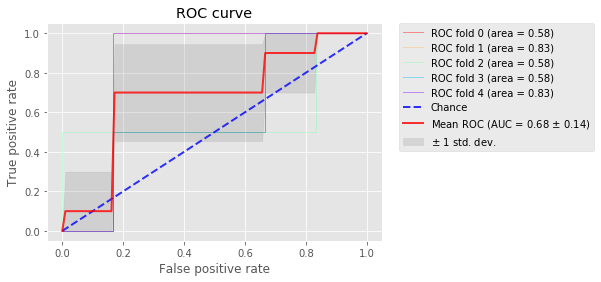

In [7]:
# For died within 90 days outcome
mean_perf = np.zeros(7)
std_perf = np.zeros(7)
auc_list = []
fpr_list = []
tpr_list = []

for i in range(5):
    # Import a sample binary outcome dataset
    train_raw = pd.read_csv('train2_90_raw' + str(i) + '.csv')
    train = pd.read_csv('train2_90_' + str(i) + '.csv')
    test = pd.read_csv('test2_90_' + str(i) + '.csv')
    
    # Separate feature matrix and labels
    features_train_raw = train_raw.drop(['NinetyMo',
                                         'MELD',
                                         'MELD_2016'],
                                        axis = 1)
    labels_train_raw = train_raw['NinetyMo']
    features_train = train.drop(['NinetyMo'], axis = 1)
    labels_train = train['NinetyMo']
    features_test = test.drop(['NinetyMo'], axis = 1)
    labels_test = test['NinetyMo']
    
    # Grid search of parameters
    grid_search_90.fit(X = features_train_raw,
                       y = labels_train_raw)
    
    # Best parameters and F1-score
    best_n_estimators = grid_search_90.best_params_['rf__n_estimators']
    best_max_depth    = grid_search_90.best_params_['rf__max_depth']
    best_f1           = grid_search_90.best_score_
    
    print('\nBest n_estimators.....', best_n_estimators)
    print('Best max_depth........', best_max_depth)
    print('Best F1...............', best_f1)
    
    # Fit the best parameters
    best_rf_90 = RandomForestClassifier(
        n_estimators = best_n_estimators,
        max_depth = best_max_depth,
        min_impurity_decrease = 0.00001,
        random_state = 0
    )
    best_rf_90.fit(features_train, labels_train)
    
    # Print the performance of the model on the test data
    perf = Performance_Metrics(best_rf_90, features_test, labels_test)
    mean_perf += perf / 5
    std_perf += np.square(perf) / 4
    
    # Store AUC, FPR, and TPR
    pred_prob = best_rf_90.predict_proba(features_test)[:, 1]
    auc_list.append(metrics.roc_auc_score(labels_test, pred_prob))
    fpr, tpr, _ = metrics.roc_curve(labels_test, pred_prob)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    
std_perf = np.sqrt(std_perf - 5 / 4 * mean_perf**2)

print('\nModel performance for 5-fold cross-validation:')
header = ['Metric', 'Mean', 'Standard deviation']
table  = [
            ['Accuracy',  mean_perf[0], std_perf[0]],
            ['F1',        mean_perf[1], std_perf[1]],
            ['Precision', mean_perf[2], std_perf[2]],
            ['Recall',    mean_perf[3], std_perf[3]],
            ['MCC',       mean_perf[4], std_perf[4]],
            ['PR-AUC',    mean_perf[5], std_perf[5]],
            ['AUC',       mean_perf[6], std_perf[6]]
         ]
print(pd.DataFrame(table, columns = header))

# Plot the ROC Curve
ROC_save_90 = ROC_Curve_CV(auc_list, fpr_list, tpr_list)
np.savetxt('ROC_save2_90_RF.csv', ROC_save_90, delimiter = ',')